### Импорт библиотек и настройки визуализации

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import StandardScaler

### Настройка стилей графиков

Эти настройки будут применяться ко всем последующим визуализациям.

In [12]:
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.edgecolor': '0.4',
    'font.family': 'DejaVu Sans'
})

sns.set_theme(
    style="whitegrid",
    palette="husl",
    font_scale=1.1,
    rc={'axes.facecolor': '#f5f5f5'}
)

pd.options.display.max_columns = 50
pd.options.display.width = 200

### Загрузка данных и проверка

In [13]:
def print_header(title):
    print(f"\n{'='*70}")
    print(f"{title:^70}")
    print(f"{'='*70}")

try:
    df = pd.read_csv('../data/row/original_data/train.csv', sep='\t', na_values=['NA', '?', '-'])
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Ошибка: Файл train.csv не найден")
    exit()

Данные успешно загружены


### Анализ данных

In [14]:
print_header('ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ')

print("\n\033[1m1. ОБЗОР ДАННЫХ:\033[0m")
print(f"• Записей: {len(df):,}")
print(f"• Признаков: {df.shape[1]}")
print("\nТипы данных:")
print(df.dtypes.value_counts().to_markdown())

# Анализ пропусков
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_pct], axis=1, 
                      keys=['Количество', '%']).query('Количество > 0')

print("\n\033[1mПропущенные значения:\033[0m")
print(missing_df.to_markdown())


                       ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ                        

1. ОБЗОР ДАННЫХ:
• Записей: 8,994
• Признаков: 13

Типы данных:
|         |   count |
|:--------|--------:|
| object  |      10 |
| float64 |       3 |

Пропущенные значения:
|               |   Количество |     % |
|:--------------|-------------:|------:|
| Salt_Solvent  |         7550 | 83.94 |
| LD50_mgkg     |         2260 | 25.13 |
| DTXSID        |         1912 | 21.26 |
| Chemical_Name |         1912 | 21.26 |
| EPA_category  |          104 |  1.16 |
| GHS_category  |           34 |  0.38 |
| nontoxic      |           13 |  0.14 |
| very_toxic    |            2 |  0.02 |


### Визуализация распределения LD50


Базовые статистики:
|           |   count |    mean |     std |   min |   1% |   5% |   25% |   50% |   75% |     95% |   99% |   max |
|:----------|--------:|--------:|--------:|------:|-----:|-----:|------:|------:|------:|--------:|------:|------:|
| LD50_mgkg |    6734 | 2268.83 | 4178.43 | 0.012 |  1.8 |   13 |   250 |   916 |  2500 | 9029.75 | 19767 | 70000 |


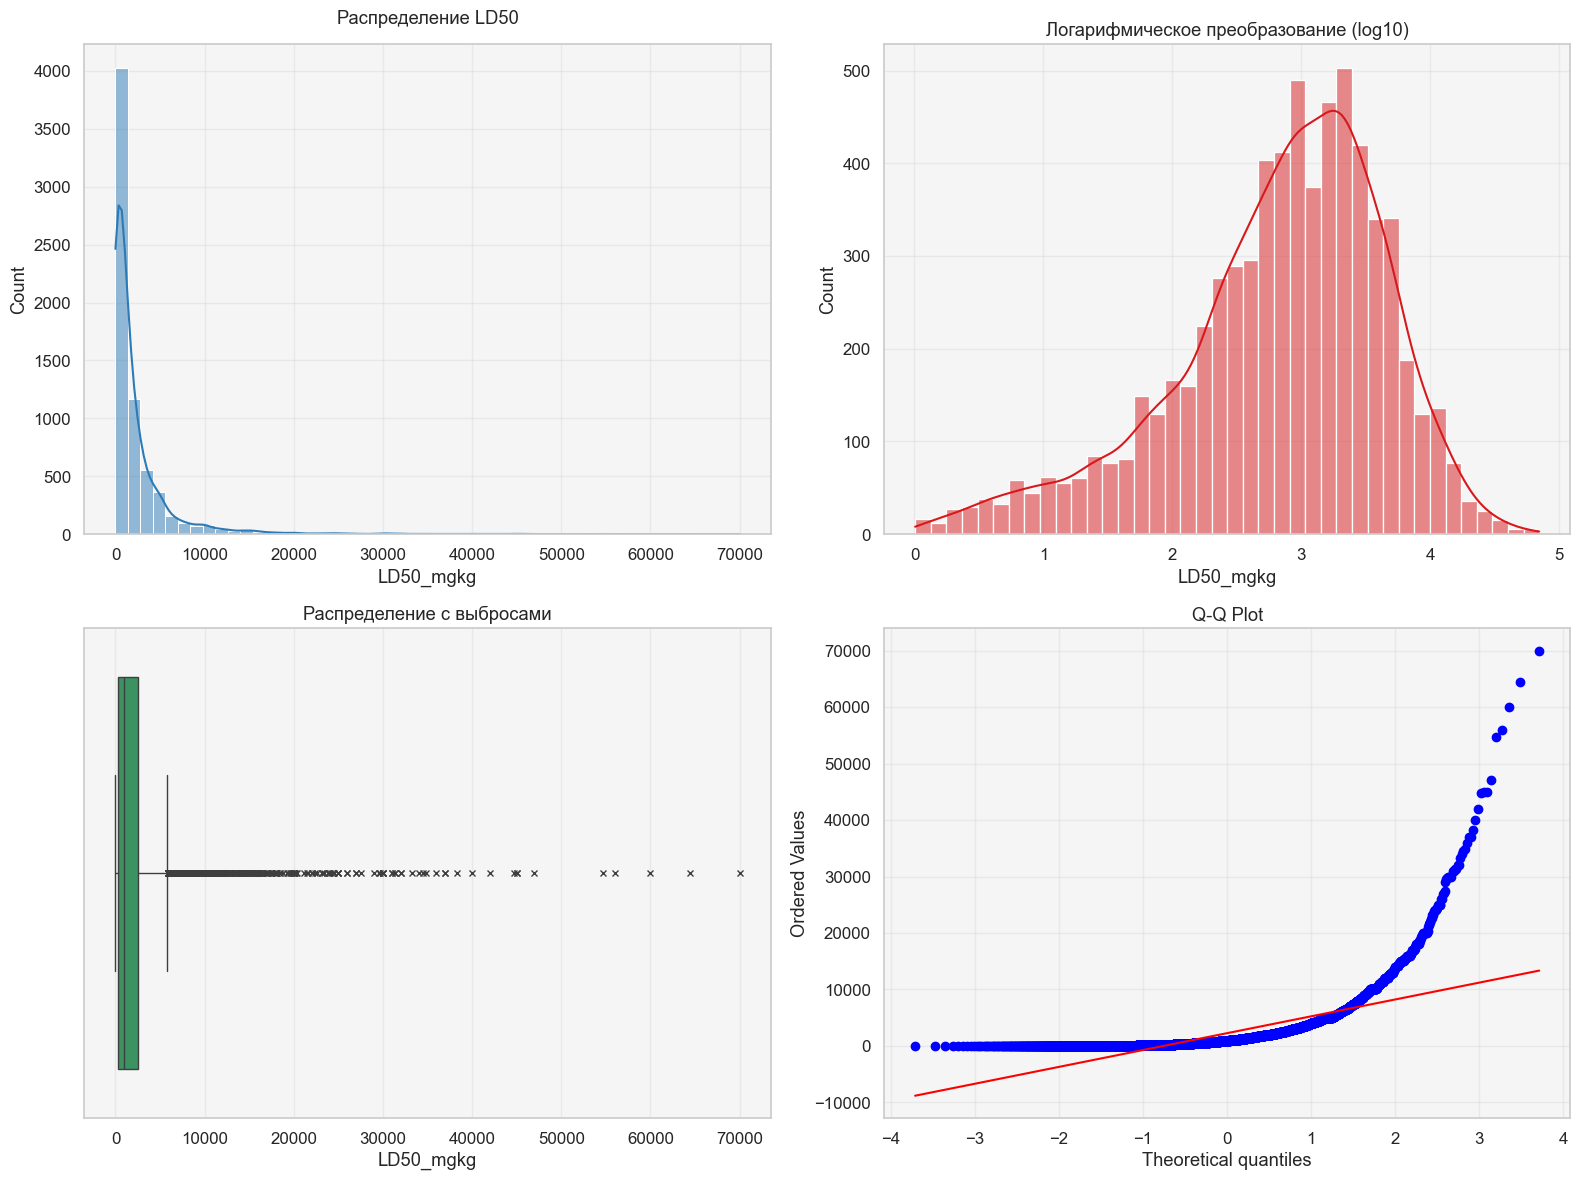

In [15]:
# Статистики
ld50_stats = df['LD50_mgkg'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
print("\n\033[1mБазовые статистики:\033[0m")
print(ld50_stats.to_frame().T.to_markdown())

# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Гистограмма распределения
sns.histplot(df['LD50_mgkg'], bins=50, kde=True, ax=axs[0,0], color='#2c7bb6', edgecolor='w')
axs[0,0].set_title('Распределение LD50', pad=15)

# Логарифмическая версия
sns.histplot(np.log10(df['LD50_mgkg'].dropna()+1), bins=40, kde=True, 
             ax=axs[0,1], color='#d7191c')
axs[0,1].set_title('Логарифмическое преобразование (log10)')

# Boxplot
sns.boxplot(x=df['LD50_mgkg'], ax=axs[1,0], color='#2ca25f', 
            flierprops={'marker': 'x', 'markersize': 4})
axs[1,0].set_title('Распределение с выбросами')

# Q-Q plot
stats.probplot(df['LD50_mgkg'].dropna(), plot=axs[1,1])
axs[1,1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

### Анализ выбросов

In [16]:
Q1 = df['LD50_mgkg'].quantile(0.25)
Q3 = df['LD50_mgkg'].quantile(0.75)
IQR = Q3 - Q1
outliers_mask = (df['LD50_mgkg'] < (Q1 - 1.5*IQR)) | (df['LD50_mgkg'] > (Q3 + 1.5*IQR))
outliers = df[outliers_mask]

In [17]:

print(f"\n\033[1mВыбросы:\033[0m {len(outliers)} ({len(outliers)/len(df):.2%})")
print("Примеры выбросов:")
print(outliers[['Chemical_Name', 'LD50_mgkg']].head().to_markdown())


Выбросы: 606 (6.74%)
Примеры выбросов:
|    | Chemical_Name                     |   LD50_mgkg |
|---:|:----------------------------------|------------:|
| 35 | Methenamine                       |        9200 |
| 41 | nan                               |        6500 |
| 58 | Picosulfate sodium                |       11300 |
| 59 | Sulfamic acid, 2-aminoethyl ester |        7460 |
| 63 | Pyrithioxin dihydrochloride       |        6000 |


### Анализ категориальных признаков

In [18]:
# Совместное распределение
cross_tab = pd.crosstab(df['EPA_category'], df['GHS_category'], normalize='index', margins=True)

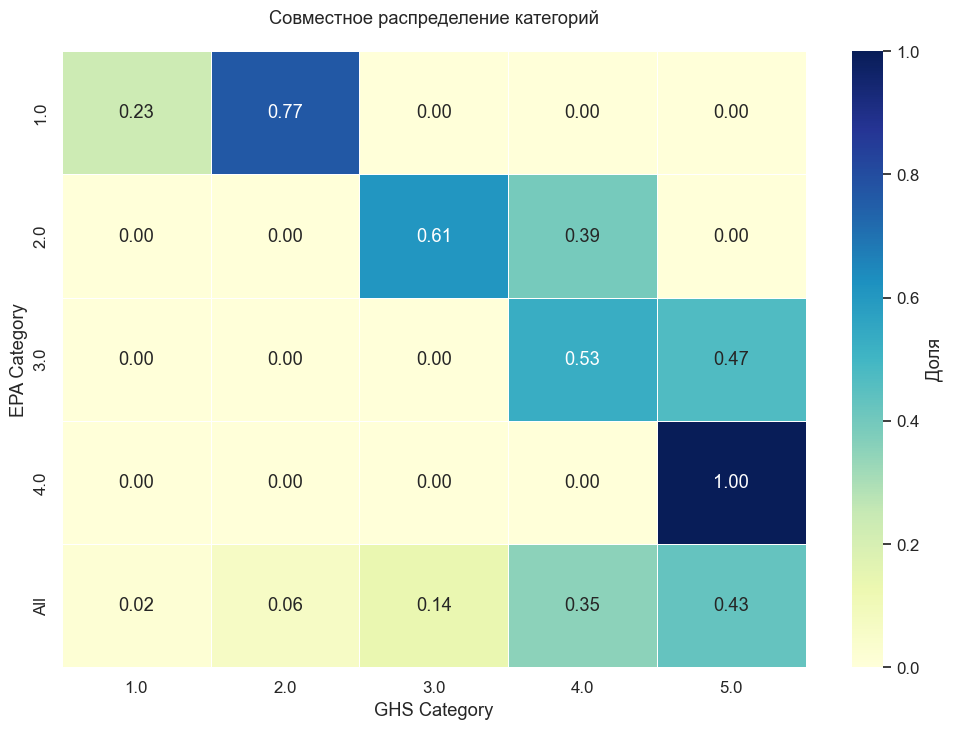

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="YlGnBu", 
            linewidths=0.5, cbar_kws={'label': 'Доля'})
plt.title('Совместное распределение категорий', pad=20)
plt.xlabel('GHS Category')
plt.ylabel('EPA Category')
plt.show()

### Анализ токсичности

In [20]:
plt.figure(figsize=(14,6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

C:\Users\PC\AppData\Local\Temp\ipykernel_20544\2858770738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='very_toxic', y='LD50_mgkg', data=df,


Text(0, 0.5, 'log(LD50)')

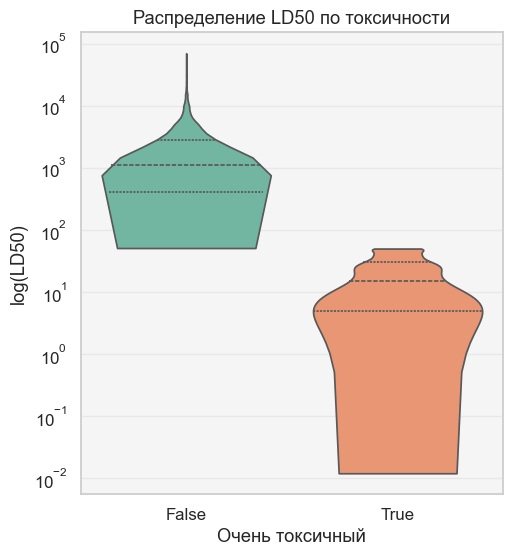

In [21]:
plt.subplot(1,2,1)
sns.violinplot(x='very_toxic', y='LD50_mgkg', data=df, 
               inner='quartile', palette='Set2', cut=0)
plt.yscale('log')
plt.title('Распределение LD50 по токсичности')
plt.xlabel('Очень токсичный')
plt.ylabel('log(LD50)')

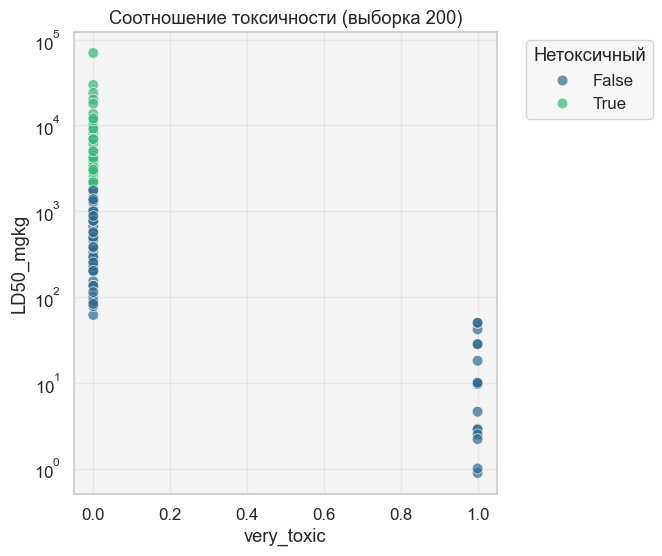

In [22]:
plt.subplot(1,2,2)
sns.scatterplot(x='very_toxic', y='LD50_mgkg', hue='nontoxic',
                data=df.sample(200, random_state=42), 
                palette='viridis', alpha=0.7, s=60)
plt.yscale('log')
plt.title('Соотношение токсичности (выборка 200)')
plt.legend(title='Нетоксичный', bbox_to_anchor=(1.05,1), loc='upper left')

In [23]:
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

###  Расширенный анализ

In [24]:
# 3D визуализация
fig = px.scatter_3d(
    df.dropna(),
    x='EPA_category',
    y='GHS_category', 
    z='LD50_mgkg',
    color='very_toxic',
    log_z=True,
    opacity=0.7,
    title='3D визуализация параметров',
    labels={'LD50_mgkg': 'log(LD50)'},
    color_discrete_sequence=['#2c7bb6', '#d7191c']
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

### Дополнительные исследования

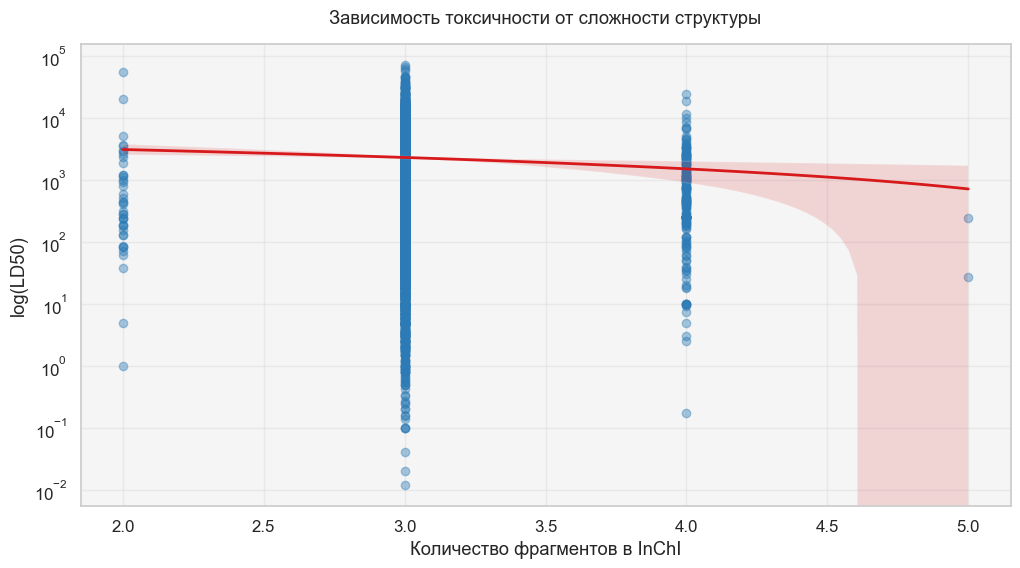

In [25]:
df['Structure_Complexity'] = df['InChI_Code_QSARr'].str.count('/')

plt.figure(figsize=(12,6))
sns.regplot(
    x='Structure_Complexity', 
    y='LD50_mgkg', 
    data=df,
    scatter_kws={'alpha':0.4, 'color':'#2c7bb6'},
    line_kws={'color':'#d7191c', 'lw':2}
)
plt.yscale('log')  # <--- Правильное применение логарифмической шкалы
plt.title('Зависимость токсичности от сложности структуры', pad=15)
plt.xlabel('Количество фрагментов в InChI')
plt.ylabel('log(LD50)')
plt.grid(True, alpha=0.3)
plt.show()